In [32]:
import time
import torch
import torch.nn as nn
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
import os
import json
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [33]:
# models
class ResidualBlock(nn.Module):
    """Residual блок для ResNet."""
    def __init__(self, in_channels, out_channels, stride=1, dropout=0.0, use_bn=True):
        super().__init__()
        self.use_bn = use_bn
        self.conv1 = nn.Conv2d(in_channels, out_channels, 3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels) if use_bn else nn.Identity()
        self.relu = nn.ReLU(inplace=True)
        self.dropout = nn.Dropout2d(dropout) if dropout > 0 else nn.Identity()
        self.conv2 = nn.Conv2d(out_channels, out_channels, 3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels) if use_bn else nn.Identity()
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, 1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels) if use_bn else nn.Identity()
            )

    def forward(self, x):
        """Выполняет прямое распространение через residual блок."""
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.dropout(out)
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        return self.relu(out)

class FCNet(nn.Module):
    """Полносвязная сеть с 4 слоями для MNIST."""
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 10)
        )

    def forward(self, x):
        """Выполняет прямое распространение входных данных через сеть."""
        return self.net(x)

class DeepFCNet(nn.Module):
    """Глубокая полносвязная сеть для CIFAR-10."""
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Flatten(),
            nn.Linear(32*32*3, 2048),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(2048, 1024),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 10)
        )

    def forward(self, x):
        """Выполняет прямое распространение входных данных через сеть."""
        return self.net(x)

class SimpleCNN(nn.Module):
    """Простая CNN с 3 сверточными слоями для MNIST."""
    def __init__(self, in_channels=1):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, 16, 3, 1)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(16, 32, 3, 1)
        self.fc1 = nn.Linear(32 * 5 * 5, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.pool(x)
        x = self.relu(self.conv2(x))
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

class ResNetLike(nn.Module):
    """Простая CNN с Residual Block для MNIST."""
    def __init__(self):
        super().__init__()
        self.conv = nn.Conv2d(1, 32, 3, padding=1)
        self.res1 = ResidualBlock(32, 64, downsample=True)
        self.res2 = ResidualBlock(64, 128, downsample=True)
        self.pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(128, 10)

    def forward(self, x):
        """Выполняет прямое распространение входных данных через сеть с residual блоками."""
        x = nn.functional.relu(self.conv(x))
        x = self.res1(x)
        x = self.res2(x)
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

class ResNetCIFAR(nn.Module):
    """ResNet с 3 residual блоками для CIFAR-10."""
    def __init__(self):
        super().__init__()
        self.conv = nn.Conv2d(3, 32, 3, padding=1, bias=False)
        self.bn = nn.BatchNorm2d(32)
        self.layer1 = ResidualBlock(32, 64, stride=2)
        self.layer2 = ResidualBlock(64, 128, stride=2)
        self.layer3 = ResidualBlock(128, 128, stride=2)
        self.pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(128, 10)

    def forward(self, x):
        """Выполняет прямое распространение входных данных через сеть с residual блоками."""
        x = nn.functional.relu(self.bn(self.conv(x)))
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

class ResNetCIFARRegularized(nn.Module):
    """ResNet с Dropout и BatchNorm для CIFAR-10."""
    def __init__(self):
        super().__init__()
        self.conv = nn.Conv2d(3, 32, 3, padding=1, bias=False)
        self.bn = nn.BatchNorm2d(32)
        self.layer1 = ResidualBlock(32, 64, stride=2, dropout=0.3, use_bn=True)
        self.layer2 = ResidualBlock(64, 128, stride=2, dropout=0.3, use_bn=True)
        self.layer3 = ResidualBlock(128, 128, stride=2, dropout=0.3, use_bn=True)
        self.pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(128, 10)
        )

    def forward(self, x):
        """Выполняет прямое распространение входных данных через сеть с регуляризацией."""
        x = nn.functional.relu(self.bn(self.conv(x)))
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

In [34]:
# utils
def get_data_loaders(dataset_name, batch_size=128):
    """Загружает и возвращает загрузчики данных для указанного датасета."""
    if dataset_name == 'MNIST':
        transform = transforms.Compose([transforms.ToTensor()])
        train = datasets.MNIST('data', train=True, download=True, transform=transform)
        test = datasets.MNIST('data', train=False, download=True, transform=transform)
        train_loader = torch.utils.data.DataLoader(train, batch_size=batch_size, shuffle=True)
        test_loader = torch.utils.data.DataLoader(test, batch_size=batch_size, shuffle=False)
        class_names = [str(i) for i in range(10)]
        return train_loader, test_loader, class_names
    elif dataset_name == 'CIFAR10':
        transform_train = transforms.Compose([
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261)),
        ])
        transform_test = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261)),
        ])
        train = datasets.CIFAR10('data', train=True, download=True, transform=transform_train)
        test = datasets.CIFAR10('data', train=False, download=True, transform=transform_test)
        train_loader = torch.utils.data.DataLoader(train, batch_size=batch_size, shuffle=True, num_workers=2)
        test_loader = torch.utils.data.DataLoader(test, batch_size=batch_size, shuffle=False, num_workers=2)
        class_names = train.classes
        return train_loader, test_loader, class_names
    else:
        raise ValueError(f"Неизвестный датасет: {dataset_name}")

def plot_grad_flow(named_parameters, save_path):
    """Визуализирует средние значения градиентов по слоям."""
    ave_grads = []
    layers = []
    for n, p in named_parameters:
        if p.requires_grad and p.grad is not None and "bias" not in n:
            layers.append(n)
            ave_grads.append(p.grad.abs().mean().item())
    plt.figure(figsize=(8,4))
    plt.plot(ave_grads, alpha=0.7, color="b")
    plt.hlines(0, 0, len(ave_grads)+1, linewidth=1, color="k" )
    plt.xticks(range(0,len(ave_grads), 1), layers, rotation="vertical", fontsize=8)
    plt.xlim(xmin=0, xmax=len(ave_grads))
    plt.xlabel("Слои")
    plt.ylabel("Средний градиент")
    plt.title("Градиентный поток")
    plt.tight_layout()
    plt.savefig(save_path)
    plt.close()

def train(model, train_loader, test_loader, epochs=20, log_prefix="", grad_flow_plot=False, grad_flow_path=None):
    device = next(model.parameters()).device
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
    history = {'train_loss': [], 'train_acc': [], 'test_loss': [], 'test_acc': []}
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        correct = 0
        total = 0
        for data, target in train_loader:
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = torch.nn.functional.cross_entropy(output, target)
            loss.backward()
            if grad_flow_plot and grad_flow_path and epoch % 5 == 0:
                plot_grad_flow(model.named_parameters(), grad_flow_path.replace('.png', f'_epoch{epoch}.png'))
            optimizer.step()
            total_loss += loss.item()
            pred = output.argmax(dim=1)
            correct += pred.eq(target).sum().item()
            total += target.size(0)
        avg_loss = total_loss / len(train_loader)
        train_acc = correct / total
        test_loss, test_acc = test(model, test_loader)
        history['train_loss'].append(avg_loss)
        history['train_acc'].append(train_acc)
        history['test_loss'].append(test_loss)
        history['test_acc'].append(test_acc)
    return history

def test(model, test_loader):
    device = next(model.parameters()).device
    model.eval()
    loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss += torch.nn.functional.cross_entropy(output, target, reduction='sum').item()
            pred = output.argmax(dim=1)
            correct += pred.eq(target).sum().item()
    loss /= len(test_loader.dataset)
    acc = correct / len(test_loader.dataset)
    return loss, acc

def get_feature_maps(model, img_tensor):
    """Возвращает feature maps первого conv-слоя для одного изображения."""
    model.eval()
    with torch.no_grad():
        for module in model.modules():
            if isinstance(module, torch.nn.Conv2d):
                return module(img_tensor).cpu().numpy()

def measure_inference_time(model, data_loader, device):
    """Измеряет среднее время инференса на одном батче."""
    model.eval()
    times = []
    with torch.no_grad():
        for data, _ in data_loader:
            data = data.to(device)
            start = time.time()
            output = model(data)
            torch.cuda.synchronize() if device.type == 'cuda' else None
            end = time.time()
            times.append(end - start)
            break  # только один батч для оценки
    return sum(times) / len(times) if times else 0

def get_predictions(model, data_loader, device):
    """Возвращает истинные и предсказанные метки для всего датасета."""
    model.eval()
    y_true = []
    y_pred = []
    with torch.no_grad():
        for data, target in data_loader:
            data = data.to(device)
            output = model(data)
            pred = output.argmax(dim=1).cpu().numpy()
            y_pred.extend(pred)
            y_true.extend(target.numpy())
    return np.array(y_true), np.array(y_pred)


def compare_models(histories, labels, save_path):
    """Сохраняет сравнение историй обучения разных моделей в файл."""
    results = {}
    for label, history in zip(labels, histories):
        results[label] = {
            'train_loss': history['train_loss'],
            'test_loss': history['test_loss'],
            'test_acc': history['test_acc'],
        }
    with open(save_path, 'w') as f:
        json.dump(results, f, indent=2)

def count_parameters(model):
    """Возвращает количество обучаемых параметров модели."""
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


def plot_metrics(histories, labels, save_dir):
    """Строит и сохраняет графики метрик обучения для нескольких моделей."""
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    metrics = ['train_loss', 'train_acc', 'test_loss', 'test_acc']
    for metric in metrics:
        plt.figure()
        for history, label in zip(histories, labels):
            plt.plot(history[metric], label=label)
        plt.title(metric)
        plt.xlabel('Epoch')
        plt.ylabel(metric)
        plt.legend()
        plt.savefig(os.path.join(save_dir, f"{metric}.png"))
        plt.close()

def plot_confusion_matrix(y_true, y_pred, class_names, save_path):
    """Строит и сохраняет confusion matrix."""
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    fig, ax = plt.subplots(figsize=(8,8))
    disp.plot(ax=ax, cmap=plt.cm.Purples, colorbar=False)
    plt.title("Confusion Matrix")
    plt.tight_layout()
    plt.savefig(save_path)
    plt.close()

## 1.1 Сравнение на MNIST

In [35]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
train_loader, test_loader, class_names = get_data_loaders('MNIST', batch_size=128)

models = [
    ("DeepFCNet", DeepFCNet().to(device)),
    ("ResNetCIFAR", ResNetCIFAR().to(device)),
    ("ResNetCIFARRegularized", ResNetCIFARRegularized().to(device))
]

histories = []
train_times = []
inference_times = []
param_counts = []
train_accs = []
test_accs = []

for name, model in models:
    params = count_parameters(model)
    param_counts.append((name, params))

    start_time = time.time()
    history = train(model, train_loader, test_loader, epochs=10, log_prefix=name, grad_flow_plot=True)
    train_duration = time.time() - start_time
    train_times.append((name, train_duration))

    train_acc = history['train_acc'][-1]
    train_accs.append((name, train_acc))

    test_loss, test_acc = test(model, test_loader)
    test_accs.append((name, test_acc))

    inf_time = measure_inference_time(model, test_loader, device)
    inference_times.append((name, inf_time))

    histories.append(history)

    y_true, y_pred = get_predictions(model, test_loader, device)
    plot_confusion_matrix(
        y_true, y_pred, class_names,
        save_path=f'PyTorch4/plots/cifar_comparison/conf_matrix_{name}.png'
    )

compare_models(histories, [n for n, _ in models], save_path='PyTorch4/results/cifar_comparison/metrics.json')
plot_metrics(histories, [n for n, _ in models], save_dir='PyTorch4/plots/cifar_comparison/')

print("\nСравнение числа параметров:")
for name, params in param_counts:
    print(f"{name}: {params}")

print("\nВремя обучения (с):")
for name, t_time in train_times:
    print(f"{name}: {t_time:.2f}")

print("\nВремя инференса (с):")
for name, i_time in inference_times:
    print(f"{name}: {i_time:.4f}")

print("\nТочность на обучающем:")
for name, tr_acc in train_accs:
    print(f"{name}: {tr_acc:.4f}")

print("\nТочность на тестовом:")
for name, t_acc in test_accs:
    print(f"{name}: {t_acc:.4f}")

RuntimeError: mat1 and mat2 shapes cannot be multiplied (128x784 and 3072x2048)

## 1.2 Сравнение на СIFAR10

FileNotFoundError: [Errno 2] No such file or directory: 'PyTorch4/plots/cifar_comparison/conf_matrix_DeepFCNet.png'

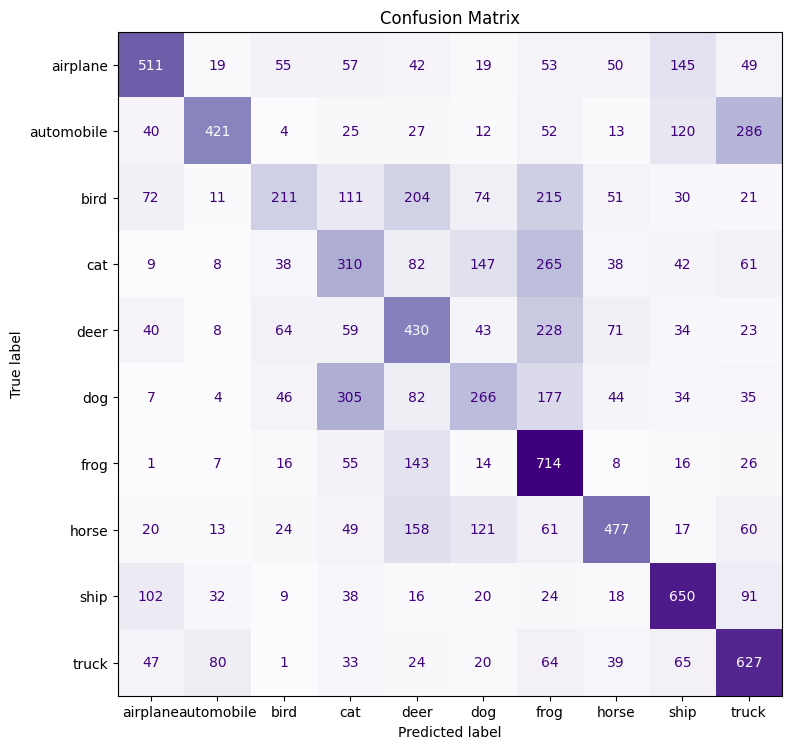

In [36]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
train_loader, test_loader, class_names = get_data_loaders('CIFAR10', batch_size=128)

models = [
    ("DeepFCNet", DeepFCNet().to(device)),
    ("ResNetCIFAR", ResNetCIFAR().to(device)),
    ("ResNetCIFARRegularized", ResNetCIFARRegularized().to(device))
]

histories = []
train_times = []
inference_times = []
param_counts = []
train_accs = []
test_accs = []

for name, model in models:
    params = count_parameters(model)
    param_counts.append((name, params))

    start_time = time.time()
    history = train(model, train_loader, test_loader, epochs=10, log_prefix=name, grad_flow_plot=True)
    train_duration = time.time() - start_time
    train_times.append((name, train_duration))

    train_acc = history['train_acc'][-1]
    train_accs.append((name, train_acc))

    test_loss, test_acc = test(model, test_loader)
    test_accs.append((name, test_acc))

    inf_time = measure_inference_time(model, test_loader, device)
    inference_times.append((name, inf_time))

    histories.append(history)

    y_true, y_pred = get_predictions(model, test_loader, device)
    plot_confusion_matrix(
        y_true, y_pred, class_names,
        save_path=f'PyTorch4/plots/cifar_comparison/conf_matrix_{name}.png'
    )

compare_models(histories, [n for n, _ in models], save_path='PyTorch4/results/cifar_comparison/metrics.json')
plot_metrics(histories, [n for n, _ in models], save_dir='PyTorch4/plots/cifar_comparison/')

print("\nСравнение числа параметров:")
for name, params in param_counts:
    print(f"{name}: {params}")

print("\nВремя обучения (с):")
for name, t_time in train_times:
    print(f"{name}: {t_time:.2f}")

print("\nВремя инференса (с):")
for name, i_time in inference_times:
    print(f"{name}: {i_time:.4f}")

print("\nТочность на обучающем:")
for name, tr_acc in train_accs:
    print(f"{name}: {tr_acc:.4f}")

print("\nТочность на тестовом:")
for name, t_acc in test_accs:
    print(f"{name}: {t_acc:.4f}")